In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import spikeinterface.full as si
from sparsesorter.models.nss import NSS
from sparsesorter.utils.metrics import compute_fscore_evolution
from sparsesorter.utils.dataloader import build_dataloader, init_dataloader
from pathlib import Path

data_path = Path("../data")

### Load Dataset


In [ ]:
datasets = ["TS1", "TS2", "TS3", "TS4"]
with_fps = [False, True]
res = {
    "TS1": {"w/ FP": [], "w/o FP": []},
    "TS2": {"w/ FP": [], "w/o FP": []},
    "TS3": {"w/ FP": [], "w/o FP": []},
    "TS4": {"w/ FP": [], "w/o FP": []},
}
for ds in datasets:
    print(f"### dataset {ds} ###")
    for fps in with_fps:
        print(f"## {'with' if fps else 'without'} FP ##")
        for s in range(20):
            print(f"# seed {s} #")
            ds_file = data_path / f"{ds}.h5"
            dataset, dataloader = build_dataloader(ds_file)
            if not fps:
                fs = dataset["fs"]
                gtr = dataset["gt_raster"]
                snr = dataset["snr"]
                peaks_idx = dataset["raster"]
                peaks_idx_copy = np.copy(peaks_idx)
                unique, counts = np.unique(gtr[1], return_counts=True)
                delta_time = 1
                tp = np.zeros(len(snr))
                fn = np.zeros_like(tp)
                fp = 0
                not_detected_gt_spikes = []
                well_detected_spikes = []
                labels_peaks = -1 * np.ones(len(peaks_idx))
                for i in range(gtr.shape[1]):
                    idx = np.where(
                        np.abs(peaks_idx_copy - gtr[0, i]) <= delta_time * fs / 1000
                    )  # search for a spike in a 1ms range
                    if idx[0].size > 0:
                        tp[gtr[1, i]] += 1
                        well_detected_spikes.append(i)
                        idx_closest = np.argmin(np.abs(peaks_idx_copy - gtr[0, i]))
                        # store the label gtr[1, i] in the labels_peaks array at the index of the detected peak in peaks_idx
                        labels_peaks[
                            np.where(peaks_idx == peaks_idx_copy[idx_closest])
                        ] = gtr[1, i]
                        peaks_idx_copy = np.delete(peaks_idx_copy, idx_closest)

                    else:
                        fn[gtr[1, i]] += 1
                        not_detected_gt_spikes.append(i)
                fp = len(peaks_idx) - len(well_detected_spikes)
                precision = tp / counts
                recall = tp / (tp + fn)
                fprate = fp / (fp + tp)

                mask = labels_peaks != -1
                dataset["wvs"] = dataset["wvs"][mask]
                dataset["raster"] = dataset["raster"][mask]
                dataloader = init_dataloader(
                    dataset["wvs"], dataset["raster"], 16, normalize=False
                )
            nss = NSS(
                input_size=dataset["wvs"].shape[1],
                net_size=[120, 10],
                threshold=0.03,
                gamma=0.05,
                lr=0.07,
                bit_width=1,
                seed=s,
            )
            nss_out, n_spikes = nss.fit_transform(dataloader)
            sorted_spikes = np.argmax(nss_out, axis=1).astype(
                int
            )  # select most active neuron
            packet_size = 200
            spike_processed, fscore_nss_packet = compute_fscore_evolution(
                sorted_spikes, dataset, packet_size
            )
            res[ds][f"w/ FP" if fps else "w/o FP"].append(fscore_nss_packet)
            print(f"f1s : {np.mean(np.mean(fscore_nss_packet, axis=0)[-5:])}")

In [ ]:
# save res dict to pickle
import pickle

with open("nss_robustness_false_positive_v2.pkl", "wb") as f:
    pickle.dump(res, f)

# # load results
# with open("nss_robustness_false_positive.pkl", "rb") as f:
#     res = pickle.load(f)

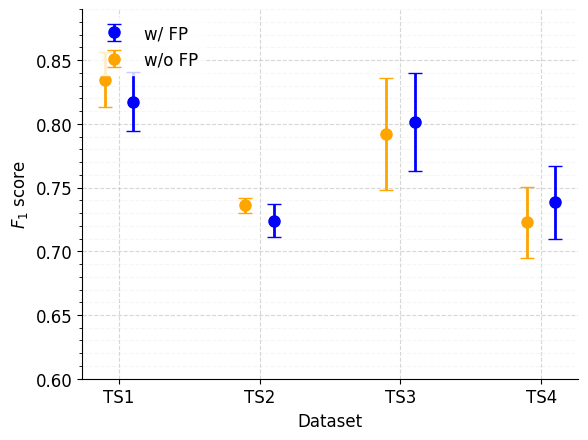

In [9]:
# compute mean and std
th = 10
fig, ax = plt.subplots()
x_pos = -1
for ds in datasets:
    x_pos += 1
    for fps in res[ds].keys():
        f1_score = np.mean(np.mean(np.array(res[ds][fps]), axis=1)[:, -th:], axis=1)
        mean, std = np.mean(f1_score), np.std(f1_score)
        int_95 = 1.96 * std / np.sqrt(len(res[ds][fps]))

        x_pos_b = x_pos + 0.1 if fps == "w/ FP" else x_pos - 0.1
        color = "blue" if fps == "w/ FP" else "orange"
        ax.errorbar(
            x_pos_b,
            mean,
            yerr=int_95,
            label=fps,
            fmt="o",
            color=color,
            capsize=5,
            elinewidth=2,
            markersize=8,
        )

ax.set_xticks(range(len(datasets)))
ax.set_xticklabels(datasets)
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.01))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.05))
ax.set_ylim(0.6, 0.89)
ax.tick_params(axis="y", which="major", labelsize=12)
ax.tick_params(axis="x", labelsize=12)
ax.set_ylabel("$F_{1}$ score", fontsize=12)
ax.set_xlabel("Dataset", fontsize=12)

handles, labels = ax.get_legend_handles_labels()
handles = [handles[0], handles[1]]
labels = [labels[0], labels[1]]
ax.legend(handles, labels, loc="upper left", fontsize=12, edgecolor="w")
ax.spines[["top", "right"]].set_visible(False)
ax.grid(True, linestyle="--", alpha=0.5)
ax.yaxis.grid(True, which="minor", linestyle="--", alpha=0.1)
# plt.savefig("nss_robustness_false_positive.svg", dpi=150, bbox_inches='tight')
plt.show()